This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Line above avoids running on GPU

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')

In [4]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [5]:
import mplhep as hep
hep.set_style('ATLAS')

In [6]:
from hh4b_utils.nnt_tools import load_nnt

In [186]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [323]:
from sklearn.metrics import auc

In [9]:
from sklearn import tree

### 1D AUC

In [10]:
print(np.arange(0, 3, 0.006).shape)
print(np.linspace(0, 3, int((3/0.006))).shape)

(500,)
(500,)


In [11]:
def auc_1d(SigArray, BkgArray, ncuts:int=100)->float:
    min_cut = np.min(SigArray)
    max_cut = np.max(SigArray)

    iterationset = np.linspace(min_cut,max_cut,ncuts)

    TPR = []
    FPR = []

    for cuti in iterationset:

        BkgCutLess = np.where(BkgArray < cuti)
        SigCutLess = np.where(SigArray < cuti)
        BkgCutMore = np.where(BkgArray > cuti)
        SigCutMore = np.where(SigArray > cuti)

        TP = float(SigCutLess[0].shape[0])
        FN = float(SigCutMore[0].shape[0])

        TN = float(BkgCutMore[0].shape[0])
        FP = float(BkgCutLess[0].shape[0])

        Sens = float(TP / (TP + FN))
        Spec = float(TN / (TN + FP))
        OneMinSpec = float(1-Spec)

        TPR.append(Sens)
        FPR.append(OneMinSpec)


    return auc(FPR, TPR)


# Classifier MVA

Lets give the good old classifier a college try

In [12]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         45G         24G         21G         55G         57G
Swap:           15G         15G        146M


In [13]:
!ls -lh /mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh/mc

total 988M
-rw-r--r-- 1 lborgna users  86M May 25 22:54 sm_hh_ellipse_mc16a.root
-rw-r--r-- 1 lborgna users  96M May 25 22:54 sm_hh_ellipse_mc16d.root
-rw-r--r-- 1 lborgna users 149M May 25 22:54 sm_hh_ellipse_mc16e.root
-rw-r--r-- 1 lborgna users  86M May 25 13:33 sm_hh_mc16a.root
-rw-r--r-- 1 lborgna users  96M May 25 13:33 sm_hh_mc16d.root
-rw-r--r-- 1 lborgna users 149M May 25 13:33 sm_hh_mc16e.root
-rw-r--r-- 1 lborgna users  86M May 25 22:55 sm_hh_xhh_mc16a.root
-rw-r--r-- 1 lborgna users  96M May 25 22:55 sm_hh_xhh_mc16d.root
-rw-r--r-- 1 lborgna users 149M May 25 22:55 sm_hh_xhh_mc16e.root


In [14]:
file_path_mc_16 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh/mc/sm_hh_mc16a.root"
file_path_mc_17 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh/mc/sm_hh_mc16d.root"
file_path_mc_18 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh/mc/sm_hh_mc16e.root"

In [309]:
mc16 = load_nnt(file_path_mc_16, trees=['sig'], flatten=False)

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


In [310]:
mc17 = load_nnt(file_path_mc_17, trees=['sig'], flatten=False)

100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


In [311]:
mc18 = load_nnt(file_path_mc_18, trees=['sig'], flatten=False)

100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


In [312]:
mc16['year'] = 16
mc17['year'] = 17
mc18['year'] = 18

In [313]:
mc16 = mc16[~mc16['pass_vbf_sel']].reset_index(drop=True)
mc17 = mc17[~mc17['pass_vbf_sel']].reset_index(drop=True)
mc18 = mc18[~mc18['pass_vbf_sel']].reset_index(drop=True)

In [314]:
mc16 = mc16.loc[mc16['X_wt_tag']>=1.5].reset_index(drop=True)
mc17 = mc17.loc[mc17['X_wt_tag']>=1.5].reset_index(drop=True)
mc18 = mc18.loc[mc18['X_wt_tag']>=1.5].reset_index(drop=True)

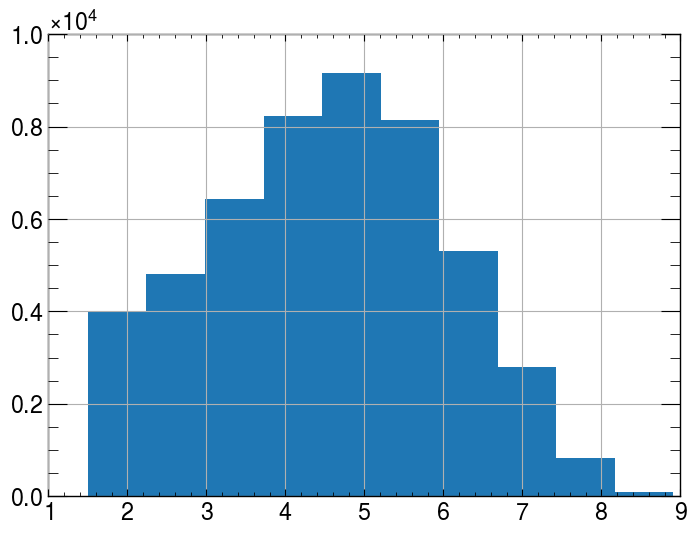

In [308]:
mc16['X_wt_tag'].hist()

In [20]:
file_path_data_16 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_16_with_weights.root"
file_path_data_17 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_17_with_weights.root"
file_path_data_18 = "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data/data_baseline_bl_18_with_weights.root"

In [21]:
data16 = load_nnt(file_path_data_16, trees=['sig'])
data17 = load_nnt(file_path_data_17, trees= ['sig'])
data18 = load_nnt(file_path_data_18, trees = ['sig'])

100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


In [22]:
f_data16 = uproot.open(file_path_data_16)
f_data17 = uproot.open(file_path_data_17)
f_data18 = uproot.open(file_path_data_18)

In [23]:
from hh4b_utils.nnt_tools import get_mu

In [24]:
norm_16 = get_mu(f_data16, 16)
norm_17 = get_mu(f_data17, 17)
norm_18 = get_mu(f_data18, 18)

In [25]:
data16['year'] = 16
data17['year'] = 17
data18['year'] = 18

In [163]:
data16['rw_to_4b'].value_counts()

False    278149
True     221575
Name: rw_to_4b, dtype: int64

In [171]:
data16 = data16.loc[data16['X_wt_tag']>=1.5].reset_index(drop=True)
data17 = data17.loc[data17['X_wt_tag']>=1.5].reset_index(drop=True)
data18 = data18.loc[data18['X_wt_tag']>=1.5].reset_index(drop=True)

In [172]:
data16 = data16.loc[
    (data16["ntag"] >= 4) | ((data16["ntag"] == 2) & (data16["rw_to_4b"] == True))
].reset_index(drop=True)

data17 = data17.loc[
    (data17["ntag"] >= 4) | ((data17["ntag"] == 2) & (data17["rw_to_4b"] == True))
].reset_index(drop=True)

data18 = data18.loc[
    (data18["ntag"] >= 4) | ((data18["ntag"] == 2) & (data18["rw_to_4b"] == True))
].reset_index(drop=True)

In [173]:
data16 = data16[~data16['pass_vbf_sel']].reset_index(drop=True)
data17 = data17[~data17['pass_vbf_sel']].reset_index(drop=True)
data18 = data18[~data18['pass_vbf_sel']].reset_index(drop=True)

In [174]:
data16['class'] = 0
data17['class'] = 0
data18['class'] = 0

In [315]:
mc16['class'] = 1
mc17['class'] = 1
mc18['class'] = 1

In [176]:
data16['NN_weights'] = norm_16 * data16['NN_d24_weight_bstrap_med_16']
data17['NN_weights'] = norm_17 * data17['NN_d24_weight_bstrap_med_17']
data18['NN_weights'] = norm_18 * data18['NN_d24_weight_bstrap_med_18']

In [316]:
mc_all = pd.concat([mc16,mc17,mc18], ignore_index=True)
signal_df = mc_all.loc[mc_all['ntag']>=4].reset_index(drop=True)

In [277]:
data_all = pd.concat([data16,data17,data18], ignore_index=True)
bkg_df = data_all.loc[data_all['ntag']==2].reset_index(drop=True)

In [317]:
signal_df['sample_weight'] = 1
bkg_df['sample_weight'] = bkg_df['NN_weights']

In [279]:
features = ['X_hh','dEta_hh','njets','X_wt_tag', 'eta_i','year']

In [318]:
df_data = pd.concat([signal_df, bkg_df], ignore_index=True)

In [319]:
df_data.head()

run_number  event_number  pass_vbf_sel             mc_sf   trig_sf  \
0      309640        285153         False   [1.8214036e-05]  1.002470   
1      307710        286651         False  [-1.0119101e-05]  1.014252   
2      310634        285723         False   [-1.209893e-05]  1.000522   
3      304178        286574         False   [1.2368362e-05]  0.999094   
4      303943        286945         False    [1.939512e-05]  1.083372   

                                        jet_trig_sfs      truth_mhh  ntag  \
0  [0.98359215259552, 0.9935654997825623, 1.00648...  539469.686412     4   
1  [0.9869453310966492, 1.0056294202804565, 1.001...  520006.020530     4   
2  [0.984768807888031, 0.9955124855041504, 1.0033...  612553.782663     4   
3  [0.9958252906799316, 0.9982829093933105, 1.006...  549449.184280     4   
4  [1.0036826133728027, 1.071120262145996, 1.0064...  450522.895701     4   

   njets      X_hh  ...  NN_d24_weight_VRderiv_bstrap_med_17  \
0      4  1.202672  ...                                  NaN   
1      4  0.345124  ...                                  NaN   
2      4  0.709134  ...                                  NaN   
3      4  0.556196  ...                                  NaN   
4      5  1.538855  ...                                  NaN   

   NN_d24_weight_VRderiv_bstrap_IQR_17  NN_d231f_weight_bstrap_med_18  \
0                                  NaN                            NaN   
1                                  NaN                            NaN   
2                                  NaN                            NaN   
3                                  NaN                            NaN   
4                                  NaN                            NaN   

   NN_d231f_weight_bstrap_IQR_18  NN_d231f_weight_VRderiv_bstrap_med_18  \
0                            NaN                                    NaN   
1                            NaN                                    NaN   
2                            NaN                                    NaN   
3                            NaN                                    NaN   
4                            NaN                                    NaN   

   NN_d231f_weight_VRderiv_bstrap_IQR_18  NN_d24_weight_bstrap_med_18  \
0                                    NaN                          NaN   
1                                    NaN                          NaN   
2                                    NaN                          NaN   
3                                    NaN                          NaN   
4                                    NaN                          NaN   

   NN_d24_weight_bstrap_IQR_18  NN_d24_weight_VRderiv_bstrap_med_18  \
0                          NaN                                  NaN   
1                          NaN                                  NaN   
2                          NaN                                  NaN   
3                          NaN                                  NaN   
4                          NaN                                  NaN   

   NN_d24_weight_VRderiv_bstrap_IQR_18  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 124 columns]

In [320]:
signal_df['mc_sf']=signal_df['mc_sf'].map(lambda x: x[0])

In [321]:
signal_df['mc_sf'].values.shape

(85707,)

# Analyze features

**RAW FEATURES**

Text(0, 0.5, 'arb.units')

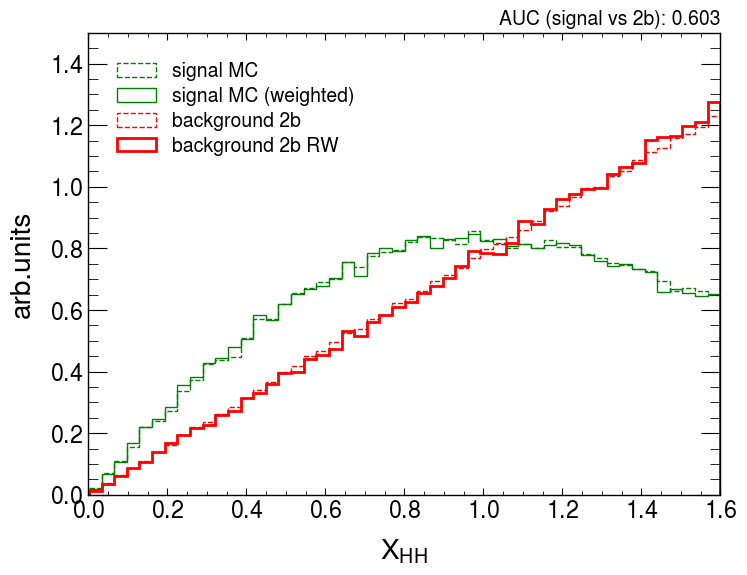

In [324]:
h_sig_raw, be, _ = plt.hist(
    signal_df["X_hh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)

h_sig_w, be, _ = plt.hist(
    signal_df["X_hh"].values,
    bins=50,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['X_hh'],bkg_df['X_hh'])
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('$X_{HH}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

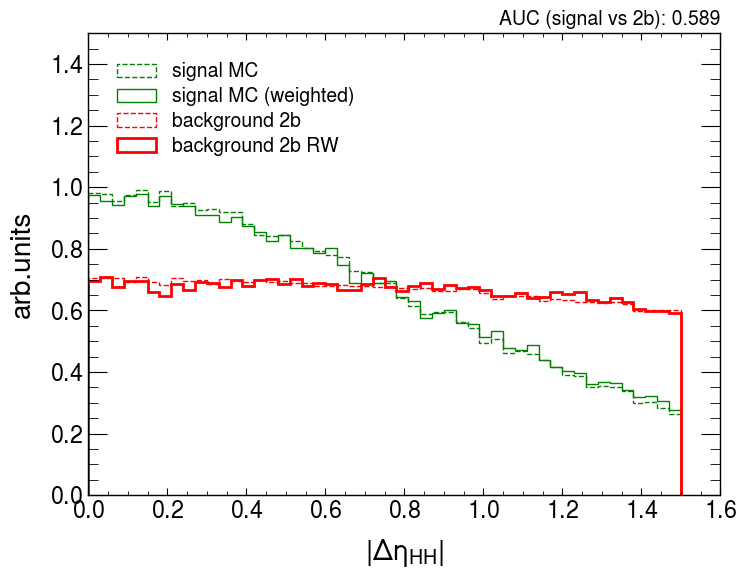

In [325]:
h_sig_raw, be, _ = plt.hist(
    signal_df["dEta_hh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, be, _ = plt.hist(
    signal_df["dEta_hh"].values,
    bins=50,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["dEta_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["dEta_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['dEta_hh'],bkg_df['dEta_hh'])
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('$|\Delta \eta_{HH}|$')
plt.ylabel('arb.units')

In [326]:
be_njets=[3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5]

Text(0, 0.5, 'arb.units')

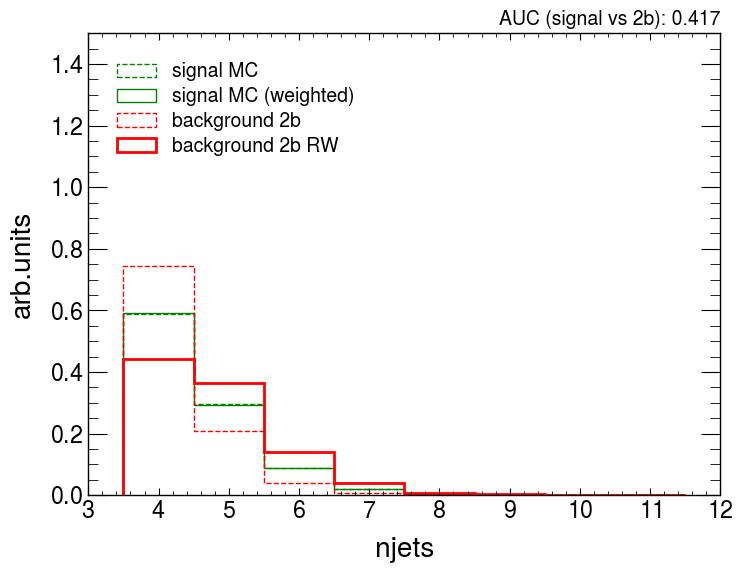

In [327]:
h_sig_raw, be, _ = plt.hist(
    signal_df["njets"].values,
    bins=be_njets,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["njets"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["njets"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["njets"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['njets'],bkg_df['njets'],ncuts=10)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('njets')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

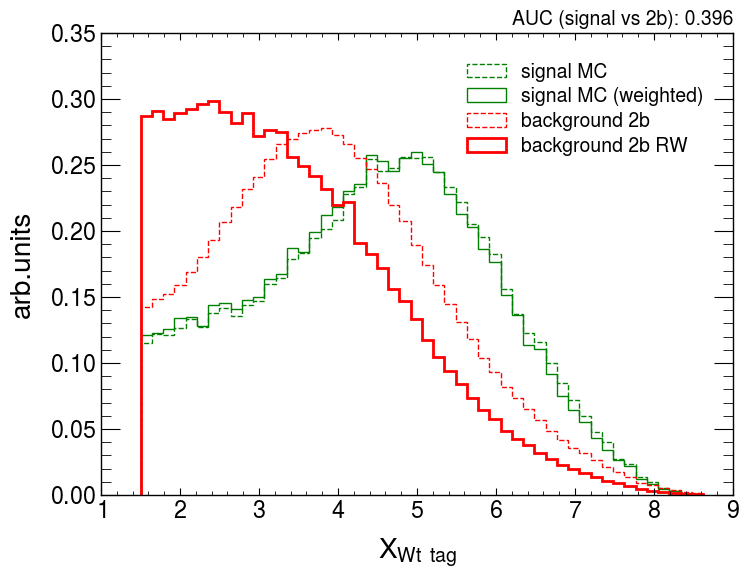

In [328]:
h_sig_raw, be, _ = plt.hist(
    signal_df["X_wt_tag"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['X_wt_tag'],bkg_df['X_wt_tag'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$X_{Wt\,\,\,  tag}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

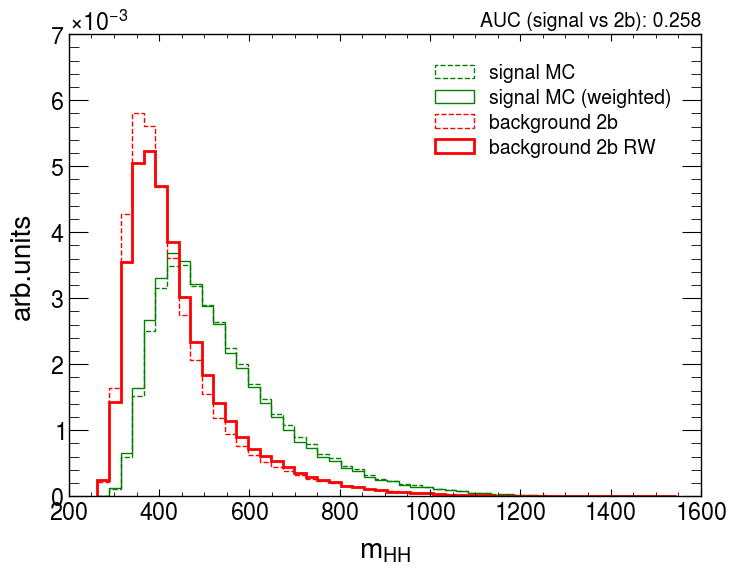

In [329]:
h_sig_raw, be, _ = plt.hist(
    signal_df["m_hh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["m_hh"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["m_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["m_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['m_hh'],bkg_df['m_hh'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$m_{HH}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

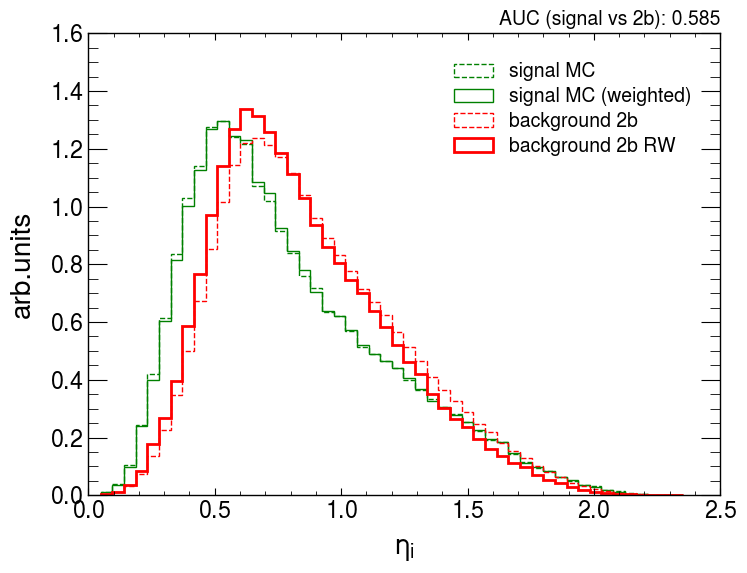

In [330]:
h_sig_raw, be, _ = plt.hist(
    signal_df["eta_i"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["eta_i"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["eta_i"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["eta_i"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['eta_i'],bkg_df['eta_i'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$\eta_{i}$')
plt.ylabel('arb.units')

# Split train_test_validate 60:20:20

In [331]:
from sklearn.model_selection import train_test_split

In [332]:
X = df_data[features]

In [333]:
X

X_hh   dEta_hh  njets  X_wt_tag     eta_i  year
0       1.202672  0.483921      4  5.494578  0.477902    16
1       0.345124  0.383692      4  4.400750  1.174169    16
2       0.709134  0.606902      4  5.394949  1.235871    16
3       0.556196  1.318419      4  5.872308  0.745159    16
4       1.538855  0.958484      5  3.804266  0.712757    16
...          ...       ...    ...       ...       ...   ...
862652  1.540596  0.717657      5  2.735349  1.098320    18
862653  1.327587  1.366138      5  5.719851  0.752196    18
862654  1.162464  1.158665      4  6.900886  0.683690    18
862655  1.521074  0.385599      5  4.507138  0.274574    18
862656  1.274521  0.257018      4  6.990841  1.642413    18

[862657 rows x 6 columns]

In [334]:
y = df_data['class']

In [335]:
idx = df_data.index

In [336]:
weights= df_data['sample_weight']

In [337]:
list(idx)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [338]:
(
    X_train,
    X_test_validate,
    y_train,
    y_test_validate,
    weights_train,
    weights_test_validate,
    idx_train,
    idx_test_validate,
) = train_test_split(X, y, weights, list(idx), test_size=0.4)
(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
    idx_test,
    idx_val,
) = train_test_split(
    X_test_validate,
    y_test_validate,
    weights_test_validate,
    idx_test_validate,
    test_size=0.5,
)

In [339]:
idx_train

[750251,
 690706,
 675360,
 618495,
 412622,
 268394,
 193190,
 523837,
 709395,
 199564,
 628038,
 386673,
 181020,
 300479,
 33457,
 300466,
 826929,
 801668,
 857991,
 485031,
 59059,
 212776,
 156482,
 413008,
 191673,
 352387,
 18901,
 846716,
 176154,
 514199,
 18788,
 37508,
 128009,
 456459,
 135616,
 130914,
 847771,
 383145,
 203195,
 789497,
 493532,
 219773,
 346100,
 284955,
 164915,
 595443,
 164607,
 487651,
 755572,
 203549,
 266930,
 18170,
 531505,
 635037,
 655747,
 688932,
 278520,
 162136,
 490550,
 82365,
 155697,
 245380,
 275649,
 85760,
 538526,
 717641,
 394559,
 180433,
 858328,
 6982,
 310321,
 405074,
 221508,
 67363,
 497827,
 564701,
 402862,
 706288,
 149010,
 332270,
 349208,
 777884,
 406042,
 392549,
 319467,
 781651,
 358483,
 807994,
 319701,
 66469,
 467271,
 557262,
 190328,
 689016,
 242115,
 474008,
 824918,
 69696,
 15756,
 41111,
 496232,
 349454,
 264358,
 176339,
 803170,
 22090,
 586437,
 811613,
 483608,
 288830,
 675132,
 32961,
 227752,


In [340]:
print(X_train.shape)
print(X_test_validate.shape)
print(y_train.shape)
print(y_test_validate.shape)
print(len(idx_train))
print(len(idx_test_validate))

(517594, 6)
(345063, 6)
(517594,)
(345063,)
517594
345063


# Weights for classes

In [341]:
N_bkg_train = weights_train[y_train == 0].sum()
print(N_bkg_train)

8889.324077088075


In [342]:
N_sig_train = weights_train[y_train==1].sum()
print(N_sig_train)

51435.0


In [343]:
R = N_bkg_train / N_sig_train

In [344]:
print(R)

0.1728263648699927


In [345]:
weights_train[y_train==1] = R

In [346]:
print(weights_train[y_train==1].sum())

8889.324077088071



**Fabulous!**

# Neural Network Classifier

In [347]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler

In [348]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [349]:
scaler = StandardScaler()

In [350]:
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

In [379]:
import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

In [351]:
from keras.utils import to_categorical

In [352]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [353]:
model = Sequential()
model.add(Dense(50, input_dim=6, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

In [354]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [355]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 50)                350       
_________________________________________________________________
dense_50 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_51 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 22        
Total params: 1,907
Trainable params: 1,907
Non-trainable params: 0
_________________________________________________________________


In [356]:
history = model.fit(
    X_train_sc,
    y_train_hot,
    sample_weight=weights_train,
    epochs=100,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, verbose=True),
        ModelCheckpoint(
            "model.h5", monitor="val_loss", verbose=True, save_best_only=True
        ),
    ],
    batch_size=1000,
    validation_data=(X_test_sc, y_test_hot, weights_test),
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 517594 samples, validate on 172531 samples
Epoch 1/100
513000/517594 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.5875
Epoch 00001: val_loss improved from inf to 0.07255, saving model to model.h5
517594/517594 [==============================] - 6s 11us/sample - loss: 0.0208 - accuracy: 0.5881 - val_loss: 0.0726 - val_accuracy: 0.6457
Epoch 2/100
516000/517594 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.6067
Epoch 00002: val_loss improved from 0.07255 to 0.06960, saving model to model.h5
517594/517594 [==============================] - 3s 6us/sample - loss: 0.0205 - accuracy: 0.6066 - val_loss: 0.0696 - val_accuracy: 0.5991
Epoch 3/100
508000/517594 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.6073
Epoch 00003: val_loss did not improve from 0.06960
517594/517594 [==============================] - 3s 6us/sample - loss: 0.0205 - accuracy: 0.6075 - va

In [357]:
model.load_weights('model.h5')

In [358]:
pred_val = model.predict(X_val_sc)

Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights) + added $\\eta_i$')

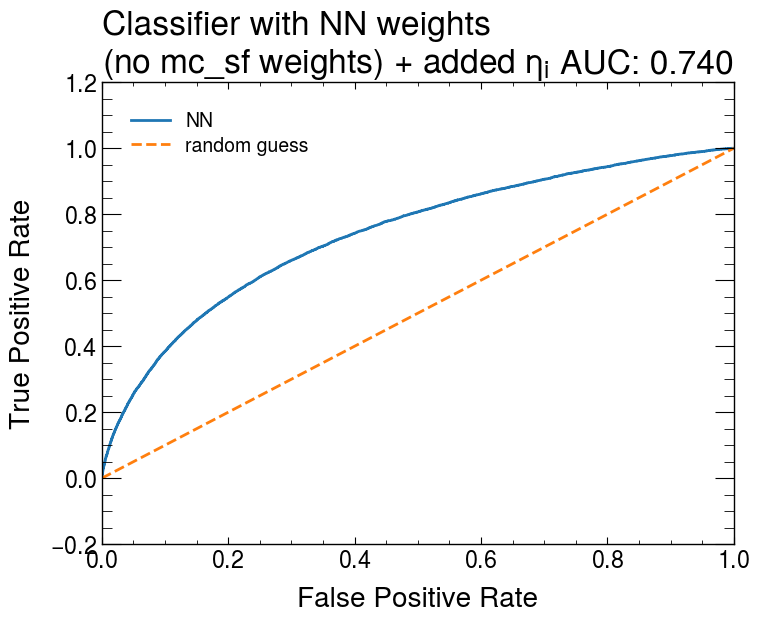

In [359]:
pred_positive = pred_val[:,1]
pred_negative = pred_val[:,0]
auc = roc_auc_score(y_val, pred_positive, sample_weight=weights_val)
fpr, tpr, _ = roc_curve(y_val, pred_positive, sample_weight=weights_val)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'NN')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights) + added $\eta_i$', loc='left')

Text(0.5, 1.0, 'NN probability score')

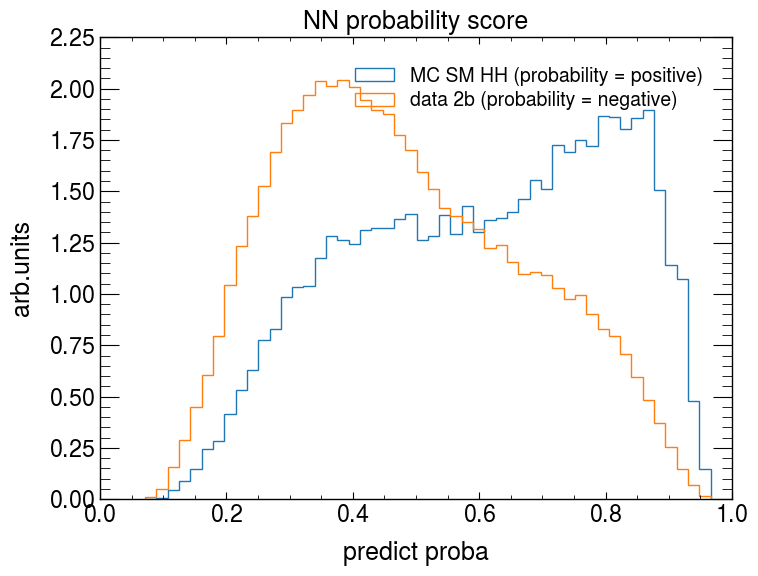

In [360]:
sm_hh_prob = pred_val[:,1][y_val==1]
data_prob = pred_val[:,1][y_val==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 50, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('NN probability score', fontsize=18)

In [361]:
X_val_test = X_val
X_val_test['pred'] = pred_val[:,1]

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


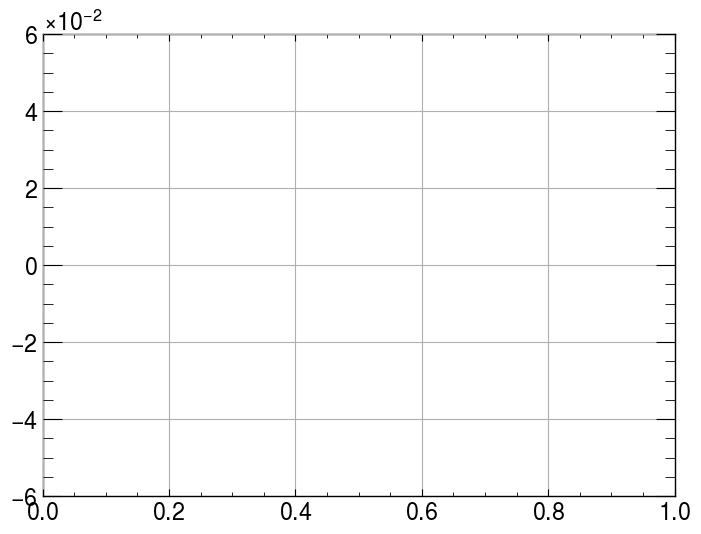

In [362]:
X_val_test.loc[X_val_test['pred']>=0.98,'X_wt_tag'].hist()

In [363]:
X_all_sc = np.concatenate([X_train_sc, X_test_sc, X_val_sc])

In [364]:
pred_all = model.predict([X_all_sc])

In [365]:
pred_all.shape

(862657, 2)

In [366]:
y_all = np.concatenate([y_train, y_test, y_val])

In [367]:
print(sum([y_train.shape[0], y_test.shape[0], y_val.shape[0]]))

862657


In [368]:
y_all.shape

(862657,)

In [369]:
weights_all = np.concatenate([weights_train, weights_test, weights_val])

In [370]:
weights_all.shape

(862657,)

Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights) + added $\\eta_i$')

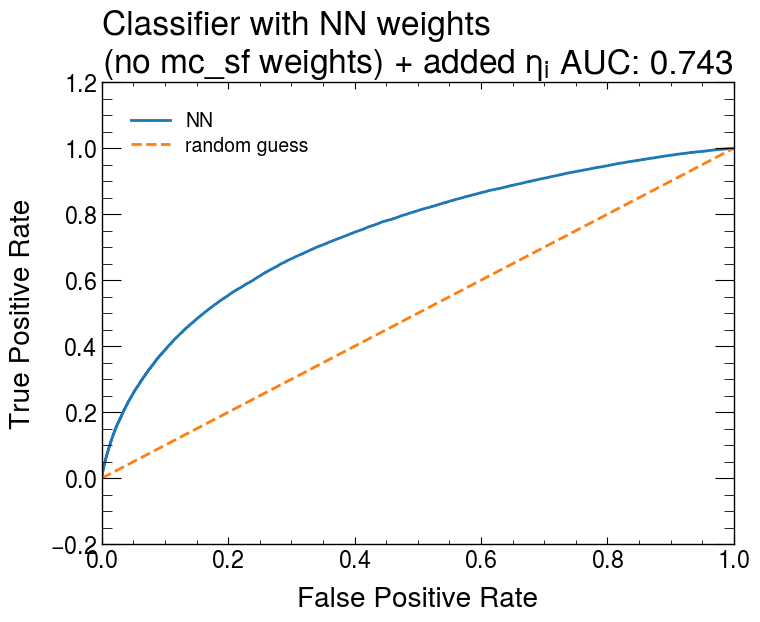

In [371]:
pred_positive = pred_all[:, 1]
pred_negative = pred_all[:, 0]
auc = roc_auc_score(
    y_all,
    pred_positive,
    sample_weight=weights_all,
)
fpr, tpr, _ = roc_curve(
    y_all,
    pred_positive,
    sample_weight=weights_all,
)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls="-", label="NN")
plt.plot(x_fpr, y_tpr, ls="--", label="random guess")
plt.legend()
plt.title("AUC: {:.3f}".format(auc), loc="right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    "Classifier with NN weights \n(no mc_sf weights) + added $\eta_i$", loc="left"
)

Text(0.5, 1.0, 'NN probability score')

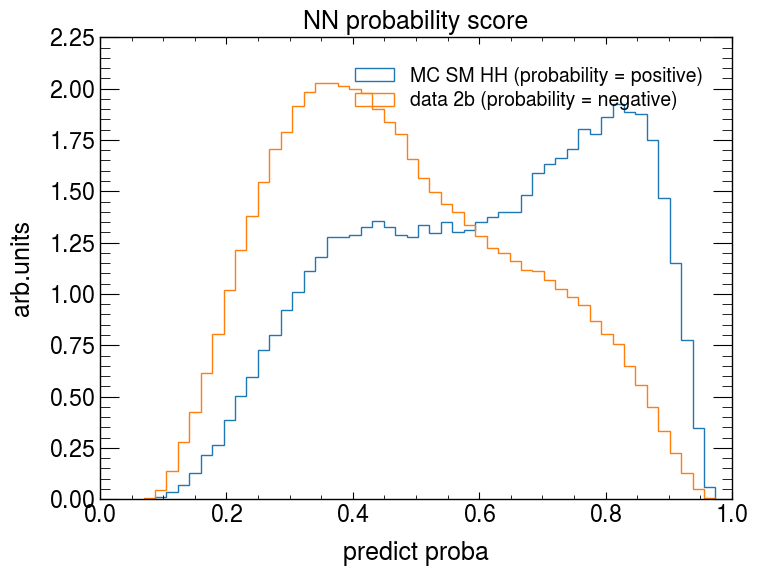

In [372]:
sm_hh_prob = pred_all[:,1][y_all==1]
data_prob = pred_all[:,1][y_all==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 50, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('NN probability score', fontsize=18)

# Writing out The files with full predictions

In [373]:
features

['X_hh', 'dEta_hh', 'njets', 'X_wt_tag', 'eta_i', 'year']

In [375]:
pred16 = model.predict(scaler.transform(data16[features]))

In [376]:
pred17 = model.predict(scaler.transform(data17[features]))
pred18 = model.predict(scaler.transform(data18[features]))

In [377]:
pred_mc16 = model.predict(scaler.transform(mc16[features]))
pred_mc17 = model.predict(scaler.transform(mc17[features]))
pred_mc18 = model.predict(scaler.transform(mc18[features]))

In [378]:
data16.head()

run_number  event_number  pass_vbf_sel  mc_sf  trig_sf  jet_trig_sfs  \
0      298771       8156622         False    1.0      1.0           1.0   
1      298771       7950178         False    1.0      1.0           1.0   
2      298771      24500264         False    1.0      1.0           1.0   
3      298771      24236970         False    1.0      1.0           1.0   
4      298771      34104092         False    1.0      1.0           1.0   

   truth_mhh  ntag  njets      X_hh  ...  rw_to_3b1f_VR  \
0        0.0     2      4  1.597552  ...           True   
1        0.0     2      4  1.095744  ...           True   
2        0.0     2      4  0.946093  ...           True   
3        0.0     2      5  0.745732  ...           True   
4        0.0     2      4  1.232613  ...           True   

   NN_d24_weight_bstrap_med_16  NN_d24_weight_bstrap_IQR_16  rw_to_4b  \
0                     0.002890                     0.001788      True   
1                     0.022788                     0.008964      True   
2                     0.007149                     0.002701      True   
3                     0.017640                     0.006872      True   
4                     0.008058                     0.003481      True   

   NN_d24_weight_VRderiv_bstrap_med_16  NN_d24_weight_VRderiv_bstrap_IQR_16  \
0                             0.003315                             0.002143   
1                             0.027970                             0.015896   
2                             0.006996                             0.002529   
3                             0.020096                             0.005823   
4                             0.007921                             0.003069   

   rw_to_4b_VR  year  class  NN_weights  
0         True    16      0    0.003047  
1         True    16      0    0.024024  
2         True    16      0    0.007536  
3         True    16      0    0.018597  
4         True    16      0    0.008495  

[5 rows x 107 columns]

In [380]:
data16['pred_pos'] = pred16[:,1]
data17['pred_pos'] = pred17[:,1]
data18['pred_pos'] = pred18[:,1]
mc16['pred_pos'] = pred_mc16[:,1]
mc17['pred_pos'] = pred_mc17[:,1]
mc18['pred_pos'] = pred_mc18[:,1]

In [381]:
data16['pred_neg'] = pred16[:,0]
data17['pred_neg'] = pred17[:,0]
data18['pred_neg'] = pred18[:,0]
mc16['pred_neg'] = pred_mc16[:,0]
mc17['pred_neg'] = pred_mc17[:,0]
mc18['pred_neg'] = pred_mc18[:,0]

In [382]:
from hh4b_utils.nnt_tools import convert_dataframe_to_nnt

In [383]:
help(convert_dataframe_to_nnt)

Help on function convert_dataframe_to_nnt in module hh4b_utils.nnt_tools:

convert_dataframe_to_nnt(df:pandas.core.frame.DataFrame, out_file_path:str)



In [384]:
convert_dataframe_to_nnt(
    data16, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data_classifier_16.root"
)
convert_dataframe_to_nnt(
    data17, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data_classifier_17.root"
)
convert_dataframe_to_nnt(
    data18, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/data_classifier_18.root"
)

100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


In [389]:
mc16.drop(columns=['jet_trig_sfs'], inplace=True)


KeyError: "['jet_trig_sfs'] not found in axis"

In [390]:
mc16['mc_sf']=mc16['mc_sf'].map(lambda x: x[0])
mc16.head(2)

run_number  event_number  pass_vbf_sel     mc_sf   trig_sf      truth_mhh  \
0      301932        286648         False  0.000011  0.966167  403792.919937   
1      311244        285509         False  0.000017  1.029873  525740.356504   

   ntag  njets      X_hh  kinematic_region  ...  eta_vbf_j2  phi_vbf_j2  \
0     3      4  0.249464                 0  ...         0.0         0.0   
1     3      4  0.915003                 0  ...         0.0         0.0   

   tagged_vbf_j2  vbf_mjj  vbf_dEtajj  vbf_pTvecsum  year  class  pred_pos  \
0          False      0.0         0.0           0.0    16      1  0.642059   
1          False      0.0         0.0           0.0    16      1  0.736993   

   pred_neg  
0  0.357941  
1  0.263007  

[2 rows x 95 columns]

In [392]:
mc17.drop(columns=['jet_trig_sfs'], inplace=True)
mc17['mc_sf']=mc17['mc_sf'].map(lambda x: x[0])

mc18.drop(columns=['jet_trig_sfs'], inplace=True)
mc18['mc_sf']=mc18['mc_sf'].map(lambda x: x[0])


In [1]:
print("hello")

hello


In [393]:
# convert_dataframe_to_nnt(
#     mc16, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh_classifier_mc16a.root"
# )
convert_dataframe_to_nnt(
    mc17, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh_classifier_mc16d.root"
)
convert_dataframe_to_nnt(
    mc18, "/mnt/storage/lborgna/NNT/cryptotuples-MAY21/sm_hh_classifier_mc16e.root"
)

100%|██████████| 1/1 [00:04<00:00,  4.67s/it]
